In [51]:
import cv2 as cv
import os
import pandas 

from skimage.filters import frangi
from skimage.util.shape import view_as_windows
from sklearn.metrics import classification_report

import numpy as np

from typing import List, Tuple

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (8,8)

In [2]:
def plt_image(image: np.ndarray, title: str = '', cmap: str = 'gray'):
    plt.title(title)
    plt.axis('off')
    plt.imshow(image, cmap=cmap)

def normalize(image: np.ndarray, factor: float) -> np.ndarray:
    image = image * (factor / image.max())
    return image

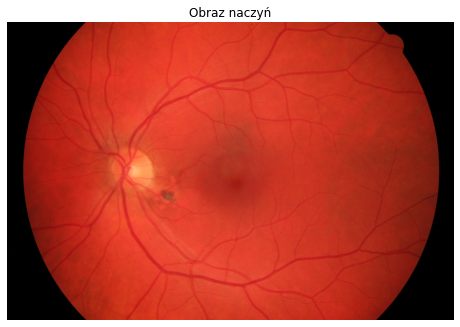

In [3]:
color_image = cv.imread('train/05_dr.JPG')
plt_image(cv.cvtColor(color_image, cv.COLOR_BGR2RGB), 'Obraz naczyń', None)

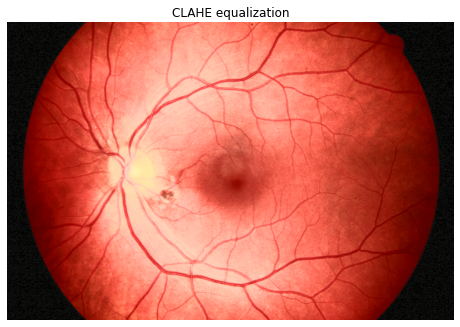

In [4]:
def color_clahe(color_img: np.ndarray) -> np.ndarray:
    ycrcb_img = cv.cvtColor(color_img, cv.COLOR_BGR2YCrCb)
    ycrcb_img[:, :, 0] = cv.equalizeHist(ycrcb_img[:, :, 0])
    return cv.cvtColor(ycrcb_img, cv.COLOR_YCrCb2BGR)

equalized = color_clahe(color_image)
plt_image(cv.cvtColor(equalized, cv.COLOR_BGR2RGB), 'CLAHE equalization', None)

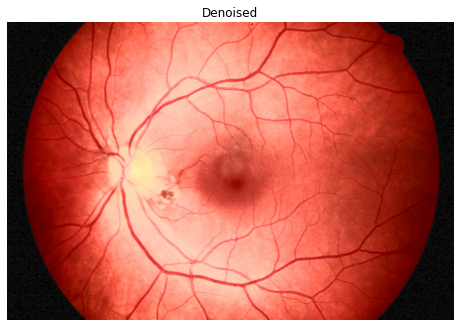

In [29]:
denoised = normalize(cv.fastNlMeansDenoisingColored(equalized, None), 255).astype(np.uint8)
plt_image(cv.cvtColor(denoised, cv.COLOR_BGR2RGB), 'Denoised', None)

In [37]:
def split_image(img: np.ndarray, size: Tuple[int, int]) -> np.ndarray:
    if size[0] % 2 == 0 or size[1] % 2 == 0:
        raise Exception('Must be odd!')
    if len(img.shape) == 3:
        return view_as_windows(img, (size[0], size[1], 3))
    else:
        return view_as_windows(img, (size[0], size[1]))

WINDOW = (21, 21)
splitted = split_image(denoised, WINDOW)
print(splitted.shape)

(2316, 3484, 1, 21, 21, 3)


In [35]:
def extract_features(img: np.ndarray) -> np.ndarray:
	winSize = (21,21)
	cellSize = (7,7)
	blockSize = (7,7)
	blockStride = (7,7)
	nbins = 9
	derivAperture = 1
	winSigma = -1.
	histogramNormType = 0
	L2HysThreshold = 0.2
	gammaCorrection = 1
	nlevels = 64
	useSignedGradients = True
	hog = cv.HOGDescriptor(winSize,blockSize,blockStride,
	cellSize,nbins,derivAperture,
	winSigma,histogramNormType,L2HysThreshold,
	gammaCorrection,nlevels, useSignedGradients)
	return hog.compute(img)

SHAPE = (splitted.shape[0] // 4, splitted.shape[1] // 4)
train = [extract_features(splitted[i, j, 0]) for i, j in np.ndindex(SHAPE)]
print(len(train))

504309


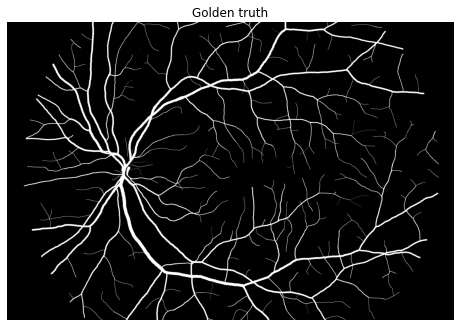

In [36]:
golden_truth = normalize(cv.imread('train/05_dr.tif', cv.IMREAD_GRAYSCALE), 255).astype(np.uint8)
plt_image(golden_truth, 'Golden truth')

In [49]:
def make_label(img: np.ndarray) -> int:
    center = (img.shape[0] // 2, img.shape[1] // 2)
    if img[center[0], center[1]] == 0:
        return 0
    return 255

truth_splitted = split_image(golden_truth, WINDOW)
labels = [make_label(truth_splitted[i, j]) for i,j in np.ndindex(SHAPE)]
print(len(labels))

504309


In [50]:
svm = cv.ml.SVM_create()
svm.setType(cv.ml.SVM_C_SVC)
svm.setKernel(cv.ml.SVM_RBF)
svm.setC(12.5)
svm.setGamma(0.50625)
svm.train(np.array(train), cv.ml.ROW_SAMPLE, np.array(labels))
svm.save('model.yml')

In [ ]:
test_image = normalize(cv.imread('train/05_dr.tif', cv.IMREAD_GRAYSCALE), 255).astype(np.uint8)